In [328]:
import time
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import torch.nn.functional as F
from plotly.offline import iplot
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

In [329]:
data_path = "LSTM Data/"
test_path = "DailyDelhiClimateTest.csv"
train_path = "DailyDelhiClimateTrain.csv"
train_data = pd.read_csv(data_path+train_path)
test_data = pd.read_csv(data_path+test_path)
train_data.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [330]:
train_data["date"] = train_data["date"].apply(pd.to_datetime)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [331]:
def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Mean Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [332]:
train_data.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [333]:
train_data_copy = train_data.copy()
train_data_copy = train_data_copy.set_index(['date'])
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [334]:
plot_dataset(train_data_copy['meantemp'], title='Mean temperature vs Date')

In [335]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler_x = get_scaler('robust')
scaler_y = get_scaler('robust')

In [336]:
train_data_copy.index = pd.to_datetime(train_data_copy.index)
train_data_copy.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [337]:
df_add_features = (
                train_data_copy
                .assign(day_of_year = train_data_copy.index.day_of_year)
              )
df_add_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
 4   day_of_year   1462 non-null   int32  
dtypes: float64(4), int32(1)
memory usage: 62.8 KB


In [338]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)   
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_add_features = generate_cyclical_features(df_add_features, 'day_of_year', 365, 0)

In [339]:
# def generate_time_lags(df, n_lags, col_name):
#     df_n = df.copy()
#     for n in range(1, n_lags + 1):
#         df_n[f"lag{n}"] = df_n[col_name].shift(n)
#     df_n = df_n.iloc[n_lags:]
#     return df_n

In [340]:
# input_dim = 5
# df_generated = generate_time_lags(df_add_features, input_dim, 'meantemp')
df_add_features.head(5)

,meantemp,humidity,wind_speed,meanpressure,sin_day_of_year,cos_day_of_year
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,0.017213,0.999852
2013-01-02,7.400000,92.000000,2.980000,1017.800000,0.034422,0.999407
2013-01-03,7.166667,87.000000,4.633333,1018.666667,0.051620,0.998667
2013-01-04,8.666667,71.333333,1.233333,1017.166667,0.068802,0.997630
2013-01-05,6.000000,86.833333,3.700000,1016.500000,0.085965,0.996298


In [341]:
test_ratio = 0.2
X_train, X_val, y_train, y_val = train_test_split(df_add_features.drop(columns=['meantemp']), df_add_features[['meantemp']], test_size=test_ratio, shuffle=False)

In [342]:
def data_pipeline(data_x, lags = 0):
    data_x["date"] = data_x["date"].apply(pd.to_datetime)
    data_x = data_x.copy()
    data_x = data_x.set_index(['date'])
    data_x.index = pd.to_datetime(data_x.index)
    plot_dataset(data_x['meantemp'], title='Mean temperature vs Date')
    df_features_x = (
                data_x
                .assign(day_of_year = data_x.index.day_of_year)
              )
    df_features_x = generate_cyclical_features(df_features_x, 'day_of_year', 365, 0)
    # df_generated = generate_time_lags(df_features_x, lags, 'meantemp')
    return df_features_x

In [343]:
test_data_gen = data_pipeline(pd.read_csv(data_path+test_path))
X_test, y_test = test_data_gen.drop(columns=['meantemp']), test_data_gen[['meantemp']]

In [344]:
x_train_arr = scaler_x.fit_transform(X_train) #data_copy[['GSR']]
X_val_arr = scaler_x.transform(X_val)
X_test_arr = scaler_x.transform(X_test)

y_train_arr = scaler_y.fit_transform(y_train)
y_val_arr = scaler_y.transform(y_val)
y_test_arr = scaler_y.transform(y_test)

In [345]:
class MyDataset(Dataset):
    
    # load the dataset
    def __init__(self, x_data, y_data):
        self.X = x_data
        self.y = y_data
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.y)
 
    # get a row at an index
    def __getitem__(self, index):
        xx = torch.from_numpy(self.X[index]).float()
        yy = torch.from_numpy(np.reshape(self.y[index], (1,1))).float()
        return torch.reshape(xx, (1, len(xx))), yy

In [346]:
cuda = torch.cuda.is_available()
num_workers = 2 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = False with num_workers = 0


In [347]:
train_data_1 = MyDataset(x_train_arr, y_train_arr)
train_args = dict(shuffle = True, batch_size = 64, 
                  num_workers = num_workers, pin_memory = True, drop_last=True) if cuda else dict(shuffle = True, batch_size = 16)
train_loader = DataLoader(train_data_1, **train_args)

# Validation dataloader
val_data = MyDataset(X_val_arr, y_val_arr)
val_args = dict(shuffle = False, batch_size = 64, 
                num_workers = num_workers, pin_memory = True) if cuda else dict(shuffle = False, batch_size = 16)
val_loader = DataLoader(val_data, **val_args)

In [348]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim,
                            batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [349]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 4
layer_dim = 2
dropout = 0
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction="mean")
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

In [350]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=0.01, verbose=False)

In [351]:
device = torch.device("cuda" if cuda else "cpu")
model.to(device)

print(model)

LSTMModel(
  (lstm): LSTM(5, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [352]:
# Train the model

def train_model(train_loader, model, criterion, optimizer):
    # print("Training...")
    
    # Set model in 'Training mode'
    model.train()

    training_loss = 0.0
    total_predictions = 0.0
    correct_prediction = 0.0

    start_time = time.time()
    
    # enumerate mini batches
    for i, (data, target) in enumerate(train_loader):
        
        # clear the gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)
        
        # compute the model output
        outputs = model(data)

        outputs = torch.reshape(outputs, target.shape)
        
        # calculate loss
        loss = criterion(outputs, target)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        training_loss += loss.item()#*data.size(0)


    end_time = time.time()
    training_loss /= len(train_loader)

    # print("Training Loss = ", training_loss, " Time = ", end_time - start_time, "s")
    # acc = (correct_prediction/total_predictions) * 100
    # print("Training accuracy = ", acc, "%")

    return training_loss, (end_time - start_time)

In [353]:
def evaluate_model(val_loader, model, criterion):

    # print("Validating...")

    with torch.no_grad():

        running_loss = 0.0
        total_predictions = 0.0
        correct_prediction = 0.0
        
        # Set model in validation mode
        model.eval()
        
        for i, (inputs, target) in enumerate(val_loader):

            inputs = inputs.to(device)
            target = target.to(device)
            
            # evaluate the model on the validation set
            out = model(inputs)

            out = torch.reshape(out, target.shape)
                    
            # Calculate validation loss
            loss = criterion(out, target).detach()

            # predicted = torch.argmax(out.data, dim=1)

            # total_predictions += target.size(0)

            # correct_prediction += (predicted == torch.argmax(target, dim=1)).float().sum().item()
            
            running_loss += loss.item()#*inputs.size(0)
        

        running_loss /= len(val_loader)

        # print("Validation Loss = ", running_loss)
        # acc = (correct_prediction/total_predictions) * 100
        # print("Training accuracy = ", acc, "%")

        return running_loss

In [354]:
epochs = 100

Train_loss = []
Test_loss = []
Test_acc = []
Train_acc = []

trial = '_LSTM_5_'
val_loss_start = 1000
train_loss_start = 1000

divs = epochs/10

for epoch in range(epochs):
    
    # print("Epoch Number = ", epoch)
    # Train
    training_loss, train_time = train_model(train_loader, model, loss_fn, optimizer)
    val_loss = evaluate_model(val_loader, model, loss_fn)

    Train_loss.append(training_loss)
    Test_loss.append(val_loss)
    # Test_acc.append(val_acc)
    # Train_acc.append(taining_acc)

    if training_loss < train_loss_start:
        PATH = "LSTM Data/model" + '/'+'trial'+str(trial)+'t.pth'
        torch.save(model.state_dict(), PATH)
        train_loss_start = training_loss

    if val_loss < val_loss_start:
        PATH = "LSTM Data/model" + '/'+'trial'+str(trial)+'v.pth'
        torch.save(model.state_dict(), PATH)
        val_loss_start = val_loss
    
    # Print log of accuracy and loss
    scheduler.step(val_loss)
    if (epoch+1)%divs == 0:
        print("Epoch: "+str(epoch+1)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss))
        print(optimizer.param_groups[0]['lr'])
        print(scheduler._last_lr)
        print("="*20, "| saved training loss = ", train_loss_start, "| saved val loss = ", val_loss_start)

dictionary = {'train_loss': Train_loss, 'val_loss': val_loss}
with open("LSTM Data/model" + '/saved_dictionary'+str(trial)+'.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

Epoch: 10, Training loss: 0.03223542400440704, Validation loss:0.04316920768714657
0.0001
[0.0001]
==================== | saved training loss =  0.03223542400440704 | saved val loss =  0.03828491455581235
Epoch: 20, Training loss: 0.030649141578406498, Validation loss:0.043366262297097
1.0000000000000002e-07
[1.0000000000000002e-07]
==================== | saved training loss =  0.03038667727014399 | saved val loss =  0.03828491455581235
Epoch: 30, Training loss: 0.030714828873405587, Validation loss:0.04336611024643246
1.0000000000000004e-08
[1.0000000000000004e-08]
==================== | saved training loss =  0.0303829105784914 | saved val loss =  0.03828491455581235
Epoch: 40, Training loss: 0.03161755747891761, Validation loss:0.043366194555633945
1.0000000000000004e-08
[1.0000000000000004e-08]
==================== | saved training loss =  0.0303829105784914 | saved val loss =  0.03828491455581235
Epoch: 50, Training loss: 0.030396698974072933, Validation loss:0.043366313237990985


In [355]:
model.load_state_dict(torch.load("LSTM Data/model" + '/trial_LSTM_5_v.pth'))

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

print(model)

LSTMModel(
  (lstm): LSTM(5, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [356]:
class DatasetTest(Dataset):
    
    # load the dataset
    def __init__(self, x_data, y_data):
        
        # store the inputs and outputs
        self.X = x_data

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, index):
            
        ### Get data at index pair with context (1 line)
        xx = torch.from_numpy(self.X[index]).float()
    
        return torch.reshape(xx, (1, len(xx)))

In [357]:
test_data_1 = DatasetTest(X_test_arr, y_test_arr)
test_args = dict(shuffle = False, batch_size = 16, 
                  num_workers = num_workers, pin_memory = True) if cuda else dict(shuffle = False, batch_size = 1)
test_loader = DataLoader(test_data_1, **test_args)

In [358]:
def final_t_model(test_loader, model):

    print("Testing...")

    with torch.no_grad():

        
        p = []
        # Set model in validation mode
        model.eval()
        
        for i, (inputs) in enumerate(test_loader):

            inputs = inputs.to(device)

            # evaluate the model on the validation set
            out = model(inputs)

            # predicted = torch.argmax(out.data, dim=1)

            p = p + (out.cpu().numpy()).tolist()

        return p

In [359]:
myP = final_t_model(test_loader, model)
myP_trans = scaler_y.inverse_transform(myP)
# s = np.asarray(myP)
# myP_trans = (s *max(data_copy_1['GSR']))
print("Done")

Testing...
Done


In [360]:
max(myP_trans)

array([32.2011104])

(array([ 7., 15., 17., 22., 10.,  9.,  5., 11., 11.,  7.]),
 array([11.  , 13.35, 15.7 , 18.05, 20.4 , 22.75, 25.1 , 27.45, 29.8 ,
        32.15, 34.5 ]),
 <BarContainer object of 10 artists>)

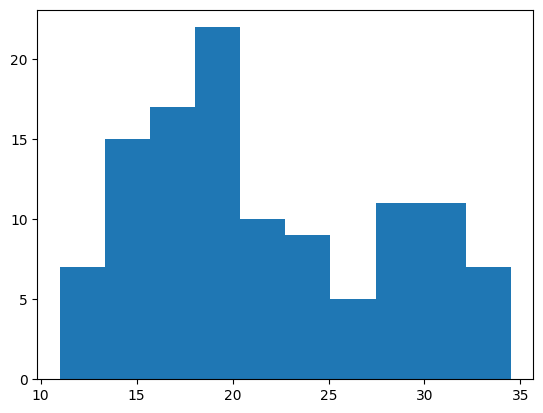

In [361]:
counts, bins = np.histogram(y_test)
plt.hist(bins[:-1], bins, weights=counts)

(array([42.,  7.,  7., 11.,  3.,  3.,  7.,  5.,  6., 23.]),
 array([14.75448792, 16.49915017, 18.24381242, 19.98847467, 21.73313691,
        23.47779916, 25.22246141, 26.96712366, 28.71178591, 30.45644815,
        32.2011104 ]),
 <BarContainer object of 10 artists>)

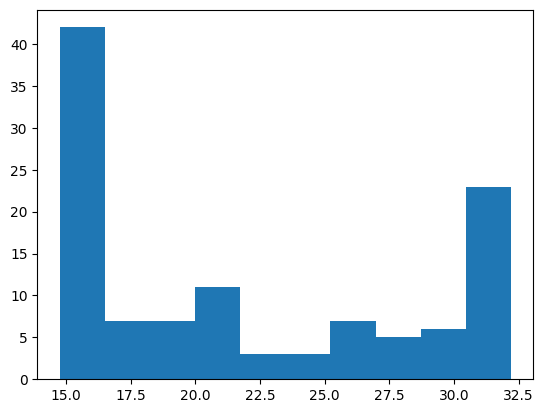

In [362]:
counts, bins = np.histogram(myP_trans)
plt.hist(bins[:-1], bins, weights=counts)

In [363]:
y_test['predicted_lstm'] = myP_trans
# y_test['predicted_unscaled'] = myP
y_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   meantemp        114 non-null    float64
 1   predicted_lstm  114 non-null    float64
dtypes: float64(2)
memory usage: 2.7 KB


/var/folders/gf/pkyzqdcn0_5021ggl3gj4sxw0000gn/T/ipykernel_76611/3639565633.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [364]:
y_true, y_pred = y_test['meantemp'], y_test['predicted_lstm']
mae = mean_absolute_error(y_true, y_pred)
r2s = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

In [365]:
print("LSTM with 5 lagged days")
print("Mean Squared Error", mse)
print("Mean Absolute Error", mae)
print("Root Mean Squared Error", rmse)
print("R2 Score", r2s)

LSTM with 5 lagged days
Mean Squared Error 7.000285471384802
Mean Absolute Error 1.9185160007403168
Root Mean Squared Error 2.6458052595353276
R2 Score 0.8254105024711413


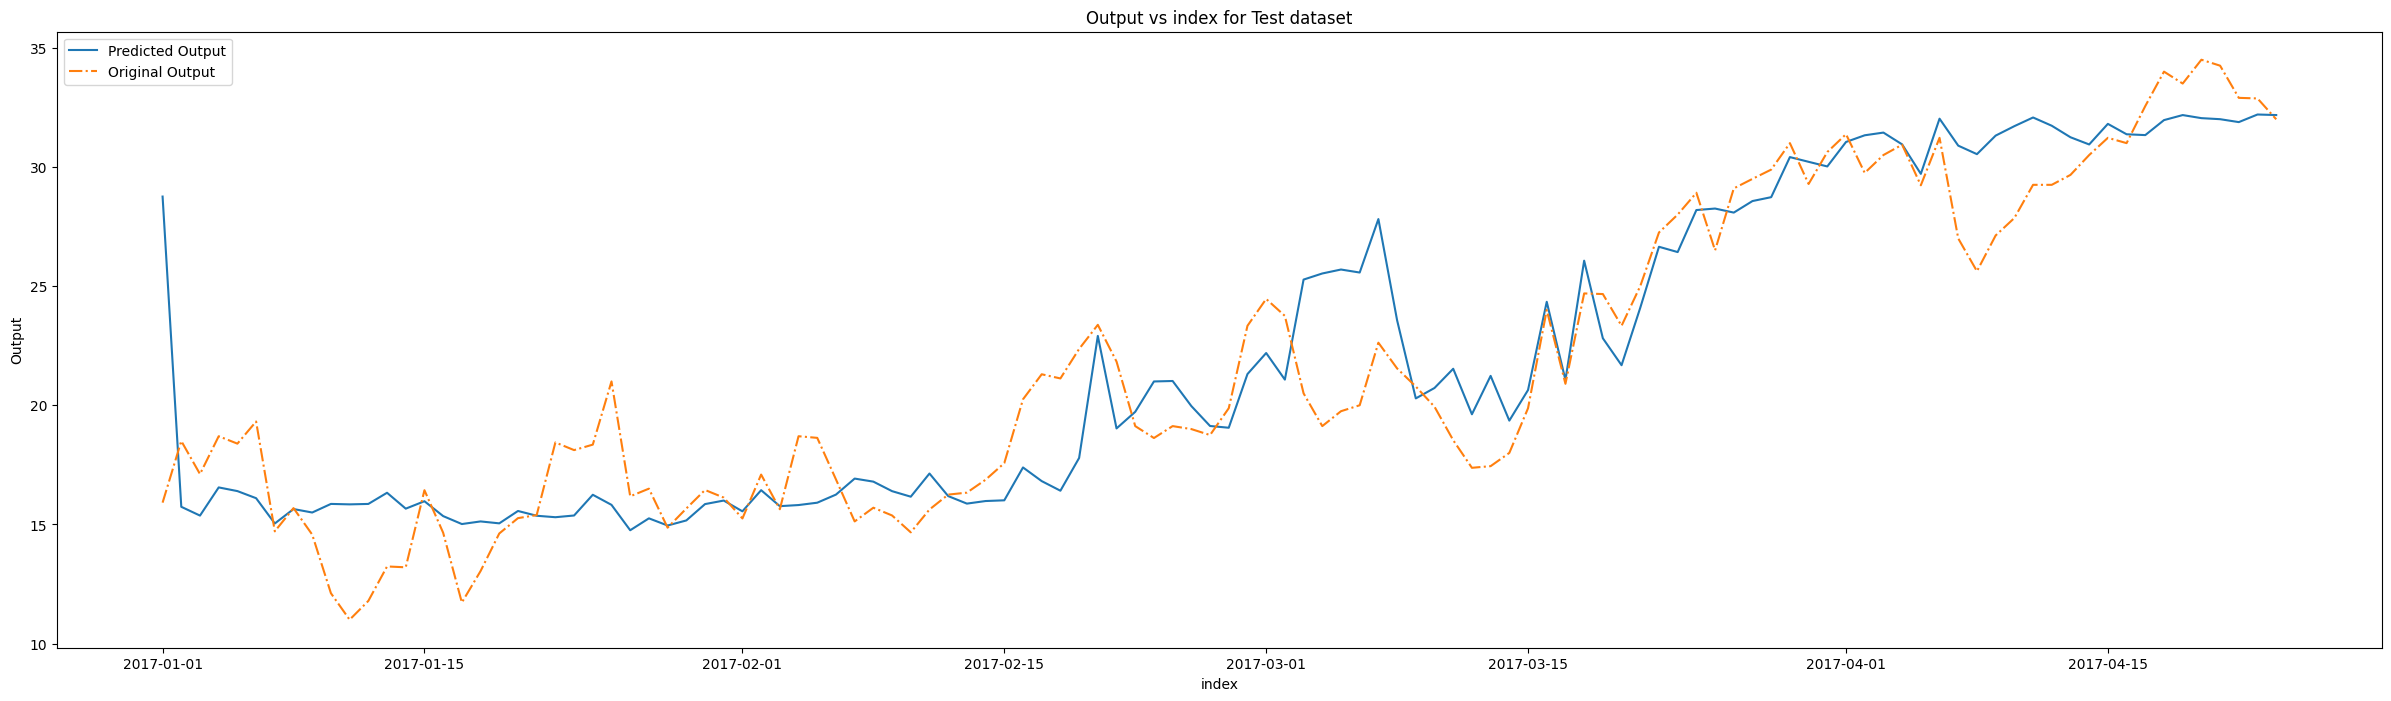

In [366]:
plt.figure(figsize=(30, 8))

plt.plot(y_test['predicted_lstm'], label='Predicted Output')
plt.plot(y_test['meantemp'], '-.', label='Original Output')

plt.xlabel("index")
plt.ylabel("Output")
plt.title('Output vs index for Test dataset')
plt.legend()
plt.show()

In [367]:
def plot_predictions(df_result):
    data = []
    
    value = go.Scatter(
        x=df_result.index,
        y=df_result.meantemp,
        mode="lines",
        name="actual values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,255, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_result.index,
        y=df_result.predicted_lstm,
        mode="lines",
        line={"dash": "dot"},
        name='LSTM',
        marker=dict(),
        text=df_result.index,
        opacity=1,
    )
    data.append(baseline)
    
    layout = dict(
        title="Predictions vs Actual Mean Temperature for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Mean Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [368]:
plot_predictions(y_test)

In [369]:
test_data_copy = pd.read_csv(data_path+test_path).drop(columns=['meantemp'])
test_data_copy.to_csv(data_path+'test_input.csv', index=False)

In [370]:
y_test['predicted_lstm'].to_csv(data_path+'beseline_output.csv')

In [371]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   meantemp        114 non-null    float64
 1   predicted_lstm  114 non-null    float64
dtypes: float64(2)
memory usage: 2.7 KB


In [372]:
test_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.7+ KB


In [373]:
y_test['meantemp'].to_csv(data_path+'output.csv')